In [1]:
import torch 
import os 
import sys
from collections import Counter
from torchvision import datasets, transforms
import copy
from tqdm import tqdm
from urllib import request
import zipfile
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler

# Add parent directory to path BEFORE importing from src
sys.path.insert(0, '..')

from torchinfo import summary 
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from src.model_builder import XceptionCustom  
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.autograd import Variable
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from sklearn.linear_model import LinearRegression
import lime
from lime import lime_image
from skimage.io import imread
from src.dataloaders import *
from src.utils import *
import warnings
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import Ridge
from pathlib import Path 
# Suppress all warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
from skimage.measure import regionprops
import networkx as nx

/Users/nicologrometto/Documents/BNN-Uncertainty-Polar-Lows/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#test_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/test'
#train_dir = '/home/nlfrx7981/uncertainty/data/polar-lows/train'

test_dir = '/Users/nicologrometto/Documents/interpretability/data/test'
train_dir = '/Users/nicologrometto/Documents/interpretability/data/train'

device = get_device('auto')
print(device)

mps


In [3]:
train_transform, test_transform = get_transforms() 
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                train_transform=train_transform,
                                                                                test_transform=test_transform)
print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
#model.load_state_dict(torch.load('../src/outputs/20.08.25_polar_lows_customex.pth'))
model.load_state_dict(torch.load('../models_local/trained_base_model.pth'))


# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")

Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       371
           1       0.91      0.97      0.94        64

    accuracy                           0.98       435
   macro avg       0.95      0.98      0.96       435
weighted avg       0.98      0.98      0.98       435


Found 8 misclassified images.


In [4]:
print(f'Size of misclassified images: {misclassified_images[0].shape}') 


Size of misclassified images: torch.Size([3, 512, 512])


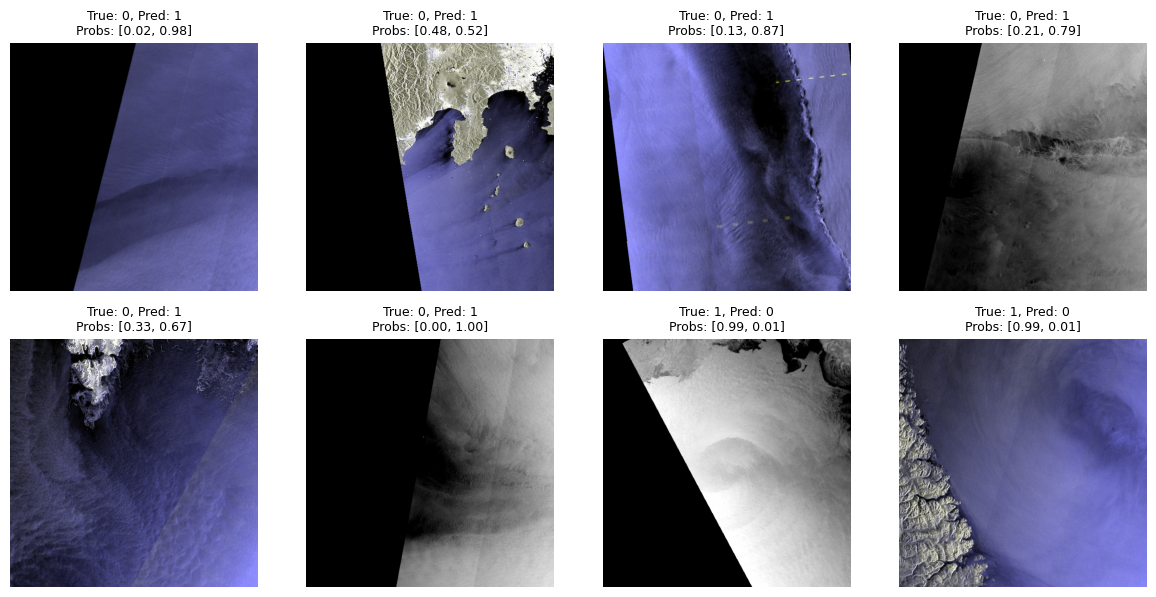

In [5]:
# --- plot misclassified images with probabilities ---
fig, axes = plt.subplots(4, 4, figsize=(12, 12)) # Create a 4x4 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(len(misclassified_images)):
    ax = axes[i]
    # Convert the image tensor (CHW) to NumPy array (HWC) for matplotlib
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Format the probability vector for display
    prob_vec = misclassified_prob_vectors[i].numpy()
    # Assuming two classes, e.g., [prob_neg, prob_pos]
    subtitle = f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}\nProbs: [{prob_vec[0]:.2f}, {prob_vec[1]:.2f}]"
    ax.set_title(subtitle, fontsize=9) # Adjust fontsize as needed
    ax.axis('off') # Turn off the axes for each subplot

# Hide any unused subplots if fewer than 16 images are displayed
for j in range(len(misclassified_images), 16):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

Original image size: (800, 800)
Transformed image shape: torch.Size([3, 512, 512])
Transformed image dtype: torch.float32
Transformed image range: [0.000, 1.000]


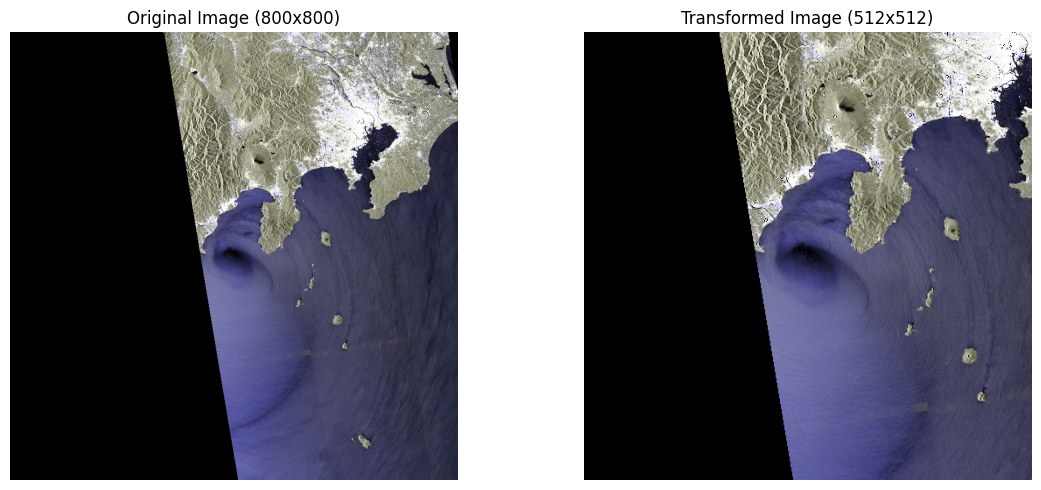

Batched image shape for model input: torch.Size([1, 3, 512, 512])
tensor([[-4.0115,  4.2003]], device='mps:0', grad_fn=<LinearBackward0>)


In [13]:
# Load sample image
image_path = Path(test_dir)/'pos'/'cffe42_20191012T084028_20191012T084212_mos_rgb.png'
image = get_image(image_path)

print(f"Original image size: {image.size}")

# Get the same transforms used for testing/inference
train_transform, test_transform = get_transforms()

# Apply the test transform (same as used during model evaluation)
transformed_image = test_transform(image)

print(f"Transformed image shape: {transformed_image.shape}")
print(f"Transformed image dtype: {transformed_image.dtype}")
print(f"Transformed image range: [{transformed_image.min():.3f}, {transformed_image.max():.3f}]")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original image
axes[0].imshow(image)
axes[0].set_title(f"Original Image ({image.size[0]}x{image.size[1]})")
axes[0].axis('off')

# Transformed image (convert tensor back to displayable format)
# PyTorch tensors are in CHW format, matplotlib expects HWC
transformed_display = transformed_image.permute(1, 2, 0)  # CHW -> HWC
axes[1].imshow(transformed_display)
axes[1].set_title(f"Transformed Image ({transformed_image.shape[1]}x{transformed_image.shape[2]})")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# The transformed_image now ready to be fed to model
# It's a tensor with shape (3, 512, 512) and values in [0, 1]

# for model inference:
batched_image = transformed_image.unsqueeze(0)  # Shape: (1, 3, 512, 512)
print(f"Batched image shape for model input: {batched_image.shape}")

model.eval()
logits_sample_img = model(batched_image.to(device))
print(logits_sample_img)

LIME image shape: (512, 512, 3)
Running LIME explanation...


100%|██████████| 100/100 [00:01<00:00, 96.59it/s]


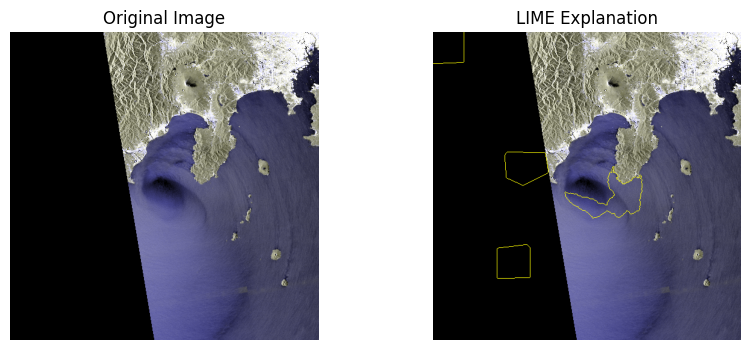

In [17]:
########
### COMPLETE LIME IMPLEMENTATION
########

# Convert tensor to numpy array for LIME
def prepare_image_for_lime(transformed_image):
    """Convert PyTorch tensor to numpy array format expected by LIME"""
    if isinstance(transformed_image, torch.Tensor):
        # Convert tensor to numpy
        img_np = transformed_image.detach().cpu().numpy()
        
        # If tensor is in CHW format (channels first), convert to HWC
        if img_np.shape[0] == 3 or img_np.shape[0] == 1:  # Check if channels first
            img_np = np.transpose(img_np, (1, 2, 0))  # CHW -> HWC
        
        # Ensure values are in [0, 255] range for LIME
        if img_np.max() <= 1.0:  # If normalized to [0,1]
            img_np = (img_np * 255).astype(np.uint8)
        else:
            img_np = img_np.astype(np.uint8)
            
        return img_np
    return transformed_image


def batch_predict(images):
    """
    Prediction function for LIME that converts numpy arrays back to tensors
    
    Args:
        images: numpy array of shape (batch_size, height, width, channels)
    Returns:
        numpy array of predictions
    """
    # Convert numpy array back to tensor format expected by your model
    if isinstance(images, np.ndarray):
        # Convert HWC to CHW format
        if len(images.shape) == 4:  # Batch of images
            images_tensor = torch.from_numpy(images).permute(0, 3, 1, 2).float()
        else:  # Single image
            images_tensor = torch.from_numpy(images).permute(2, 0, 1).float().unsqueeze(0)
        
        # Normalize to [0,1] if needed (if your model expects [0,1] range)
        if images_tensor.max() > 1.0:
            images_tensor = images_tensor / 255.0
            
        # Move to device if needed
        images_tensor = images_tensor.to(device)
    else:
        images_tensor = images
    
    # Get model predictions
    model.eval()
    with torch.no_grad():
        predictions = torch.softmax(model(images_tensor), dim=1)
        # Convert to numpy for LIME
        if isinstance(predictions, torch.Tensor):
            predictions = predictions.detach().cpu().numpy()
    
    return predictions


def custom_slic_segmentation(image, n_segments=100, compactness=10, start_label=1, sigma=1):
    return slic(image, n_segments=n_segments, compactness=compactness, 
                sigma=sigma, start_label=start_label)


# Running LIME
# Assume you have your transformed_image tensor from earlier
image = get_image(image_path)

# Convert tensor to format expected by LIME
lime_image_np = prepare_image_for_lime(transformed_image)

print(f"LIME image shape: {lime_image_np.shape}")

# Now run LIME explanation
print("Running LIME explanation...")
explainer_standard = lime_image.LimeImageExplainer()

explanation = explainer_standard.explain_instance(
    lime_image_np,  # Use numpy array instead of tensor
    batch_predict,  # Updated prediction function
    top_labels=2,   # For binary classification
    num_samples=100,
    segmentation_fn=custom_slic_segmentation
)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], # extract top class by prediction confidence
                                            positive_only=True, 
                                            num_features=5, 
                                            hide_rest=False)
'''
note: LIME doesn't automatically split the features 50/50 between positive and negative contributions. 
Instead, it selects the 10 most important features overall (by abs value) regardless of whether they're positive or negative contributions.
'''
img_boundry = mark_boundaries(temp/255.0, mask)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.array(lime_image_np))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_boundry)
plt.title('LIME Explanation')
plt.axis('off')
plt.show()

# Bayesian LIME

In [20]:
class CompleteBayesianLIME:
    def __init__(self, model):
        self.model = model
        self.device = next(model.parameters()).device
    
    def create_superpixels(self, image, n_segments=150, compactness=10):
        """
        Create superpixels using SLIC algorithm
        
        Args:
            image: RGB image array (H, W, 3)
            n_segments: number of superpixels to create
            compactness: balance between color similarity and spatial proximity
        
        Returns:
            segments: label array (H, W) with superpixel IDs
        """
        segments = slic(
            image, 
            n_segments=n_segments, 
            compactness=compactness,
            start_label=0,
            channel_axis=-1
        )
        return segments
    

    def get_superpixel_centers(self, segments):
        """Get centroid coordinates for each superpixel"""
        props = regionprops(segments + 1)  # regionprops expects 1-indexed labels
        centers = np.array([[prop.centroid[0], prop.centroid[1]] for prop in props])
        return centers
    
    
    def plot_image_boundaries_centers(self, image, segments, centers):
        plt.figure(figsize=(3, 3))
        plt.imshow(mark_boundaries(image, segments))

        # Unpack the centers into x and y for plotting
        y_coords, x_coords = zip(*centers)

        plt.scatter(x_coords, y_coords, c='red', s=30, marker='x')  # Plot centers
        plt.title('Superpixels with Centers')
        plt.show()

    
    def build_superpixel_graph(self, segments):
        """
        Build adjacency graph where superpixels are connected if they share a boundary
        
        Returns:
            adjacency_matrix: sparse matrix (n_superpixels, n_superpixels)
        """
        n_superpixels = segments.max() + 1
        h, w = segments.shape
        
        # Find adjacent superpixels by checking 4-connectivity
        adjacencies = set()
        
        # Check horizontal adjacencies
        for i in range(h):
            for j in range(w - 1):
                if segments[i, j] != segments[i, j + 1]:
                    sp1, sp2 = segments[i, j], segments[i, j + 1]
                    adjacencies.add((min(sp1, sp2), max(sp1, sp2)))
        
        # Check vertical adjacencies  
        for i in range(h - 1):
            for j in range(w):
                if segments[i, j] != segments[i + 1, j]:
                    sp1, sp2 = segments[i, j], segments[i + 1, j]
                    adjacencies.add((min(sp1, sp2), max(sp1, sp2)))
        
        # Build sparse adjacency matrix
        row_indices = []
        col_indices = []
        
        for sp1, sp2 in adjacencies:
            row_indices.extend([sp1, sp2])
            col_indices.extend([sp2, sp1])
        
        # Add self-connections (distance 0)
        for i in range(n_superpixels):
            row_indices.append(i)
            col_indices.append(i)
        
        data = np.ones(len(row_indices))
        adjacency_matrix = csr_matrix(
            (data, (row_indices, col_indices)), 
            shape=(n_superpixels, n_superpixels)
        )
        return adjacency_matrix
    
    
    def compute_graph_distances(self, adjacency_matrix):
        """
        Compute shortest path distances on the superpixel graph
        
        Returns:
            distances: matrix (n_superpixels, n_superpixels) with graph distances
        """
        # Compute shortest paths (number of hops between superpixels)
        distances = shortest_path(
            adjacency_matrix, 
            method='auto',
            directed=False,
            unweighted=True
        )
        return distances
    
    
    def build_prior(self, image, segments):
        """
        Build prior using graph distances
        """
        centers = self.get_superpixel_centers(segments)
        
        # Build superpixel adjacency graph
        adjacency = self.build_superpixel_graph(segments)
        graph_distances = self.compute_graph_distances(adjacency)
        
        # prior mean: general visual informativeness
        prior_mean = self._compute_prior_mean(image, segments)
        
        # GRAPH-BASED covariance: spatial correlation using graph distances
        prior_cov = self._compute_graph_covariance(image, centers, graph_distances)
        return prior_mean, prior_cov
    

    def _compute_prior_mean(self, image, segments):
        """
        Prior mean based on general visual informativeness
        """
        gray = rgb2gray(image)
        n_superpixels = segments.max() + 1
        
        prior_means = []
        
        # Global image statistics
        global_std = np.std(gray)
        global_mean = np.mean(gray)
        gradient = sobel(gray)
        global_edge_mean = np.mean(gradient)
        
        for i in range(n_superpixels):
            mask = segments == i
            
            if np.sum(mask) == 0:  # Skip empty superpixels
                prior_means.append(0.0)
                continue
            
            # Feature 1: Local contrast
            local_std = np.std(gray[mask])
            contrast_score = local_std / global_std if global_std > 0 else 0
            
            # Feature 2: Edge density
            edge_density = np.mean(gradient[mask])
            normalized_edge = edge_density / global_edge_mean if global_edge_mean > 0 else 0
            
            # Feature 3: Local complexity (texture)
            complexity_score = np.var(gray[mask])
            
            # Feature 4: Uniqueness (deviation from global mean)
            region_mean = np.mean(gray[mask])
            uniqueness_score = abs(region_mean - global_mean) / global_std if global_std > 0 else 0
            
            # Combine into general informativeness score
            informativeness = (contrast_score + normalized_edge + complexity_score + uniqueness_score) / 4
            
            prior_means.append(informativeness)
        
        # Normalize
        prior_means = np.array(prior_means)
        if np.std(prior_means) > 0:
            prior_means = (prior_means - np.mean(prior_means)) / np.std(prior_means)
        
        return prior_means * 0.2  # Conservative scaling
    

    def _compute_graph_covariance(self, image, centers, graph_distances):
        """
        Compute covariance matrix using graph distances 
        """
        gray = rgb2gray(image)
        n_superpixels = len(centers)
        
        # Estimate correlation length in graph hops
        # Use median graph distance as a scale reference
        finite_distances = graph_distances[graph_distances < np.inf]
        if len(finite_distances) > 0:
            typical_graph_distance = np.median(finite_distances)
            correlation_hops = max(2.0, typical_graph_distance / 3)  # Decay over ~1/3 of typical distance
        else:
            correlation_hops = 3.0  # Default fallback
        
        # Build correlation matrix using graph distances
        correlations = np.zeros((n_superpixels, n_superpixels))
        
        for i in range(n_superpixels):
            for j in range(n_superpixels):
                if graph_distances[i, j] < np.inf:
                    # Exponential decay based on graph distance
                    correlations[i, j] = np.exp(-graph_distances[i, j] / correlation_hops)
                else:
                    # Disconnected superpixels have zero correlation
                    correlations[i, j] = 0.0
        
        # Adaptive variance based on image complexity
        image_complexity = np.std(sobel(gray))
        base_variance = 0.1 + 0.4 * np.tanh(image_complexity)
        
        # Final covariance matrix
        covariance = base_variance * correlations
        covariance += 1e-6 * np.eye(n_superpixels)  # Numerical stability
        
        return covariance
    
    
    def explain_image(self, image, target_class=None, n_segments=100, compactness=10, n_samples=10):
        """
        Complete pipeline: create superpixels → build graph → explain with Bayesian LIME
        
        Args:
            image: RGB image array (H, W, 3)
            target_class: int, class index to explain (if None, uses predicted class)
            n_segments: number of superpixels to create
            compactness: SLIC compactness parameter
            n_samples: number of samples for LIME
        
        Returns:
            dict with explanation results
        """
        # Step 1: Create superpixels
        segments = self.create_superpixels(image, n_segments, compactness)
        
        # Step 2: Build graph-based prior
        prior_mean, prior_cov = self.build_prior(image, segments)
        
        # Step 3: Generate samples and predictions
        samples = self.spatial_sampling(segments, n_samples)
        predictions = self.get_predictions(image, segments, samples)
        
        # Step 4: Get original prediction to determine target class if not specified
        if target_class is None:
            # Get prediction for original image
            input_tensor = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
            self.model.eval()
            with torch.inference_mode():
                original_logits = self.model(input_tensor)
                target_class = torch.argmax(original_logits, dim=1).item()
        
        # Step 5: Use logits for the target class
        y = predictions[:, target_class]  # Logits for target class
        
        posterior_mean, posterior_cov = self.bayesian_regression(
            samples, y, prior_mean, prior_cov
        )
        
        return {
            'segments': segments,
            'posterior_mean': posterior_mean,
            'posterior_std': np.sqrt(np.diag(posterior_cov)),
            'posterior_cov': posterior_cov,
            'prior_mean': prior_mean,
            'prior_cov': prior_cov,
            'n_superpixels': segments.max() + 1,
            'target_class': target_class
        }
        

    def spatial_sampling(self, segments, n_samples=100):

        """Generate spatially coherent samples using graph-based distances"""
        n_superpixels = segments.max() + 1
        
        # Compute graph distances once (not in the loop)
        adjacency = self.build_superpixel_graph(segments)
        graph_distances = self.compute_graph_distances(adjacency)
        
        samples = []
        for _ in range(n_samples):  # Fix: underscore, not asterisk
            focus = np.random.choice(n_superpixels)
            
            # Fix: use parentheses for indexing, get the row for this focus
            distances_to_focus = graph_distances[focus, :]
            
            # Compute probabilities with base probability for disconnected regions
            probabilities = np.exp(-distances_to_focus / np.max(distances_to_focus))

            sample = np.random.random(n_superpixels) < probabilities
            samples.append(sample)
        
        return np.array(samples)


   
    def get_predictions(self, image, segments, samples):
        """Get model logits for perturbed images"""
        predictions = []
        self.model.eval()
        
        for sample in tqdm(samples):
            perturbed = image.copy()
            for i in range(segments.max() + 1):
                if not sample[i]:
                    perturbed[segments == i] = 0
            
            input_tensor = torch.from_numpy(perturbed).permute(2, 0, 1).unsqueeze(0).float().to(self.device)
            
            with torch.inference_mode():
                logits = self.model(input_tensor)
                print(logits)
                predictions.append(logits.cpu().numpy()[0])  # Store logits directly
        
        return np.array(predictions)
    

    def bayesian_regression(self, X, y, prior_mean, prior_cov, noise_var=0.01):
        """Bayesian linear regression (same as before)"""
        prior_precision = np.linalg.inv(prior_cov)
        data_precision = X.T @ X / noise_var
        
        posterior_precision = data_precision + prior_precision
        posterior_cov = np.linalg.inv(posterior_precision)
        
        posterior_mean = posterior_cov @ (
            X.T @ y / noise_var + prior_precision @ prior_mean
        )
        
        return posterior_mean, posterior_cov
    
    def plot_top_k_segments_with_boundaries(self, image, segments_slic, beta, k=5, boundary_color=(1, 1, 0)):
        """
        Plot the original image with yellow boundaries around the union of the top-k most important superpixels.

        Args:
            img (np.ndarray): Original image, shape (H, W, C).
            segments_slic (np.ndarray): Superpixel labels, shape (H, W).
            beta (np.ndarray): Importance coefficients for each superpixel.
            k (int): Number of top superpixels to highlight.
            boundary_color (tuple): RGB color for the superpixel boundaries.
        """
        # Get top-k superpixel indices
        top_k_indices = np.argsort(beta)[-k:]

        # Create a mask to keep only top-k segments
        mask = np.isin(segments_slic, top_k_indices)

        # Create a new segment map where non-top-k segments are assigned a dummy label (-1)
        # and all top-k segments are merged into a single label (e.g., 0)
        masked_segments = np.full_like(segments_slic, fill_value=-1)
        masked_segments[mask] = 0  # merge all selected superpixels into one segment

        # Plot with yellow boundaries
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.imshow(mark_boundaries(image, masked_segments, color=boundary_color, mode='thick'))
        ax.set_title(f"Top-{k} Superpixels (Merged with Yellow Boundaries)")
        ax.axis('off')
        plt.show()



In [80]:
explainer = CompleteBayesianLIME(model)

# One-line explanation with automatic superpixel creation and graph distances
explanation = explainer.explain_image(lime_image_np, n_segments=200, compactness=10)

# Results
segments = explanation['segments']
importance = explanation['posterior_mean']
uncertainty = explanation['posterior_std']

print(f"Created {explanation['n_superpixels']} superpixels")
print(f"Explanation shape: {importance.shape}")


 40%|████      | 4/10 [00:00<00:00, 16.74it/s]

tensor([[ 158.5329, -152.9604]], device='cuda:0')
tensor([[-98.8727,  97.6870]], device='cuda:0')
tensor([[ 22.4119, -21.7304]], device='cuda:0')
tensor([[ 218.5993, -212.4587]], device='cuda:0')
tensor([[-31.0411,  31.3044]], device='cuda:0')


100%|██████████| 10/10 [00:00<00:00, 20.25it/s]

tensor([[-57.0139,  57.6606]], device='cuda:0')
tensor([[ 118.4105, -115.6243]], device='cuda:0')
tensor([[ 12.9099, -14.1832]], device='cuda:0')
tensor([[-102.3150,  100.1894]], device='cuda:0')
tensor([[ 31.1938, -30.7032]], device='cuda:0')
Created 156 superpixels
Explanation shape: (156,)


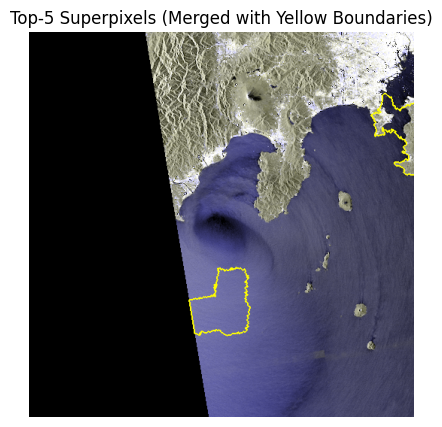

In [81]:
explainer.plot_top_k_segments_with_boundaries(lime_image_np, segments, importance, k=5, boundary_color=(1, 1, 0))

# Continuous LIME

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.linear_model import Ridge
from sklearn.metrics import pairwise_distances
from skimage.segmentation import quickshift
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

class ContinuousLIME:
    """
    Continuous LIME variant where superpixels are dimmed with uniform[0,1] weights
    instead of binary on/off perturbations.
    """
    
    def __init__(self, model, mode='classification'):
        """
        Initialize Continuous LIME explainer.
        
        Args:
            model: PyTorch model that outputs probabilities
            mode: 'classification' or 'regression'
        """
        self.model = model
        self.mode = mode
        
        # Set model to eval mode if it's a PyTorch model
        if hasattr(self.model, 'eval'):
            self.model.eval()
    
    def explain_instance(self, image, num_samples=1000, num_features=10, 
                        distance_metric='cosine', kernel_width=0.25,
                        segmentation_fn=None, random_state=None):
        """
        Explain a single instance using continuous perturbations.
        
        Args:
            image: Input image as numpy array (H, W, C) or (C, H, W)
            num_samples: Number of perturbation samples to generate
            num_features: Number of top features to return
            distance_metric: Distance metric for weighting samples
            kernel_width: Width of the exponential kernel
            segmentation_fn: Function to generate superpixels
            random_state: Random seed for reproducibility
            
        Returns:
            ContinuousLIMEExplanation object
        """
        if random_state is not None:
            np.random.seed(random_state)
            torch.manual_seed(random_state)
        
        # Ensure image is in the right format (H, W, C)
        if len(image.shape) == 3 and image.shape[0] == 3:
            image = image.transpose(1, 2, 0)
        
        # Generate superpixels
        if segmentation_fn is None:
            segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2)
        else:
            segments = segmentation_fn(image)
        
        n_features = len(np.unique(segments))
        
        # Generate continuous perturbation data
        data, labels = self._generate_continuous_data_labels(
            image, segments, num_samples
        )
        
        # Get distances and weights
        distances = pairwise_distances(
            data, data[0].reshape(1, -1), 
            metric=distance_metric
        ).ravel()
        
        weights = np.sqrt(np.exp(-(distances**2) / kernel_width**2))
        
        # Fit local linear model
        used_features = range(n_features)
        easy_model = Ridge(alpha=1, fit_intercept=True, random_state=random_state)
        easy_model.fit(data[:, used_features], labels, sample_weight=weights)
        
        prediction_score = easy_model.score(
            data[:, used_features], labels, sample_weight=weights
        )
        
        # Get original prediction
        original_pred = self._predict_fn(image.reshape(1, *image.shape))[0]
        
        return ContinuousLIMEExplanation(
            image=image,
            segments=segments,
            intercept=easy_model.intercept_,
            local_exp=list(zip(used_features, easy_model.coef_)),
            score=prediction_score,
            original_prediction=original_pred,
            num_features=num_features
        )
    
    def _generate_continuous_data_labels(self, image, segments, num_samples):
        """Generate continuous perturbation data and corresponding labels."""
        n_features = len(np.unique(segments))
        
        # Generate continuous perturbation vectors
        # Each entry is sampled from Uniform[0,1]
        data = np.random.uniform(0, 1, size=(num_samples, n_features))
        
        # Add the original image (all features at full intensity)
        data[0] = np.ones(n_features)
        
        # Generate perturbed images and get predictions
        imgs = []
        for row in data:
            perturbed_img = self._perturb_image_continuous(image, segments, row)
            imgs.append(perturbed_img)
        
        imgs = np.array(imgs)
        labels = self._predict_fn(imgs)
        
        return data, labels
    
    def _perturb_image_continuous(self, image, segments, weights):
        """
        Apply continuous perturbation to image based on superpixel weights.
        
        Args:
            image: Original image
            segments: Superpixel segmentation
            weights: Continuous weights for each superpixel [0,1]
            
        Returns:
            Perturbed image
        """
        perturbed = image.copy()
        
        for i, weight in enumerate(weights):
            # Find pixels belonging to this superpixel
            mask = segments == i
            
            # Apply continuous dimming: multiply pixel values by weight
            perturbed[mask] = perturbed[mask] * weight
        
        return perturbed
    
    def _predict_fn(self, images):
        """Get model predictions for a batch of images."""
        # Convert to tensor and normalize if needed
        if isinstance(images, np.ndarray):
            if len(images.shape) == 3:
                images = images[None, ...]  # Add batch dimension
            
            # Convert to tensor and rearrange dimensions (B, H, W, C) -> (B, C, H, W)
            images_tensor = torch.FloatTensor(images).permute(0, 3, 1, 2)
        else:
            images_tensor = images
        
        with torch.no_grad():
            outputs = self.model(images_tensor)
            
            if self.mode == 'classification':
                # Return probabilities for the positive class (class 1)
                if outputs.shape[1] == 2:  # Binary classification
                    probs = F.softmax(outputs, dim=1)
                    return probs[:, 1].cpu().numpy()  # Return prob of positive class
                else:
                    return F.softmax(outputs, dim=1).cpu().numpy()
            else:
                return outputs.cpu().numpy()


class ContinuousLIMEExplanation:
    """Explanation object for Continuous LIME results."""
    
    def __init__(self, image, segments, intercept, local_exp, score, 
                 original_prediction, num_features):
        self.image = image
        self.segments = segments
        self.intercept = intercept
        self.local_exp = dict(local_exp)
        self.score = score
        self.original_prediction = original_prediction
        self.num_features = num_features
        
        # Sort features by importance (absolute value of coefficients)
        self.top_labels = sorted(
            self.local_exp.keys(), 
            key=lambda x: abs(self.local_exp[x]), 
            reverse=True
        )[:num_features]
    
    def get_image_and_mask(self, label, positive_only=False, hide_rest=False, num_features=5):
        """
        Get explanation visualization similar to original LIME.
        
        Args:
            label: Superpixel label to explain
            positive_only: Only show positive contributions
            hide_rest: Hide non-important superpixels
            num_features: Number of features to highlight
            
        Returns:
            (image, mask) tuple
        """
        if label not in self.local_exp:
            raise ValueError(f"Label {label} not in explanation")
        
        # Get top features
        if positive_only:
            top_features = [f for f in self.top_labels[:num_features] 
                          if self.local_exp[f] > 0]
        else:
            top_features = self.top_labels[:num_features]
        
        # Create explanation image
        temp = self.image.copy()
        mask = np.zeros(self.segments.shape)
        
        for f in top_features:
            mask[self.segments == f] = self.local_exp[f]
            
            if hide_rest and f not in top_features:
                temp[self.segments == f] = 0
        
        return temp, mask
    
    def show_explanation(self, label=None, positive_only=False, num_features=5, 
                        figsize=(15, 5)):
        """Visualize the explanation."""
        if label is None:
            label = self.top_labels[0]
        
        temp, mask = self.get_image_and_mask(
            label, positive_only=positive_only, num_features=num_features
        )
        
        fig, axes = plt.subplots(1, 3, figsize=figsize)
        
        # Original image
        axes[0].imshow(self.image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        # Explanation overlay
        axes[1].imshow(temp)
        axes[1].imshow(mask, alpha=0.7, cmap='RdYlBu_r')
        axes[1].set_title(f'Continuous LIME Explanation\n(Pred: {self.original_prediction:.3f})')
        axes[1].axis('off')
        
        # Feature importance bar plot
        top_features = self.top_labels[:num_features]
        importances = [self.local_exp[f] for f in top_features]
        colors = ['green' if imp > 0 else 'red' for imp in importances]
        
        axes[2].barh(range(len(top_features)), importances, color=colors)
        axes[2].set_yticks(range(len(top_features)))
        axes[2].set_yticklabels([f'Feature {f}' for f in top_features])
        axes[2].set_xlabel('Continuous Importance')
        axes[2].set_title('Feature Importance')
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig


# Example usage and comparison functions
def compare_lime_variants(model, image, num_runs=5, random_state=42):
    """
    Compare standard binary LIME with continuous LIME across multiple runs
    to analyze stability and uncertainty.
    """
    np.random.seed(random_state)
    
    continuous_explainer = ContinuousLIME(model)
    
    continuous_results = []
    
    print("Running Continuous LIME multiple times...")
    for i in range(num_runs):
        explanation = continuous_explainer.explain_instance(
            image, num_samples=1000, random_state=random_state + i
        )
        
        # Extract feature importances
        importances = [explanation.local_exp.get(f, 0) for f in range(len(explanation.local_exp))]
        continuous_results.append(importances)
    
    continuous_results = np.array(continuous_results)
    
    # Calculate statistics
    continuous_mean = np.mean(continuous_results, axis=0)
    continuous_std = np.std(continuous_results, axis=0)
    
    return {
        'continuous_mean': continuous_mean,
        'continuous_std': continuous_std,
        'continuous_results': continuous_results
    }


def uncertainty_analysis(results, top_k=10):
    """Analyze uncertainty in explanations."""
    continuous_mean = results['continuous_mean']
    continuous_std = results['continuous_std']
    
    # Get top features by mean importance
    top_features = np.argsort(np.abs(continuous_mean))[-top_k:][::-1]
    
    print("\nUncertainty Analysis (Top {} features):".format(top_k))
    print("-" * 50)
    print(f"{'Feature':<8} {'Mean Imp':<10} {'Std Dev':<10} {'CV':<10}")
    print("-" * 50)
    
    for f in top_features:
        cv = continuous_std[f] / (abs(continuous_mean[f]) + 1e-8)  # Coefficient of variation
        print(f"{f:<8} {continuous_mean[f]:<10.4f} {continuous_std[f]:<10.4f} {cv:<10.4f}")
    
    return top_features


# Example model wrapper for your Xception model
class ModelWrapper:
    """Wrapper to ensure model outputs probabilities for LIME."""
    def __init__(self, model):
        self.model = model
        self.model.eval()
    
    def __call__(self, x):
        with torch.no_grad():
            logits = self.model(x)
            probs = F.softmax(logits, dim=1)
            return probs
    
    def eval(self):
        """Make wrapper compatible with PyTorch model interface."""
        self.model.eval()
        return self
    
    def train(self):
        """Make wrapper compatible with PyTorch model interface."""
        self.model.train()
        return self


# Usage example:

# Load your trained model
wrapped_model = ModelWrapper(model)

# Load and preprocess your image
image = lime_image_np

# Create explainer and generate explanation
explainer = ContinuousLIME(wrapped_model)
explanation = explainer.explain_instance(image, num_samples=1000)

# Visualize results
explanation.show_explanation(num_features=10)

# Run uncertainty analysis
results = compare_lime_variants(wrapped_model, image, num_runs=10)
top_features = uncertainty_analysis(results)

82

In [24]:
'''
def uniform_blurred_samples(image, num_samples, n_segments=100, compactness=10, sigma=1, start_label=1):
    """
    Generate multiple samples of uniformly blurred images using superpixels.
    """
    
    # Generate superpixels once 
    segments = slic(image, n_segments, compactness)
    unique_segments = np.unique(segments)
    
    # Generate ALL weights at once - shape (num_samples, n_superpixels)
    uniform_weights = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))
    
    # Convert image to float once
    base_image = image.copy().astype(np.float32)
    
    samples = []
    
    for sample_idx in range(num_samples):
        # Start with a fresh copy of the base image for each sample
        blurred_image = base_image.copy()
        
        # Apply the weights for THIS sample
        for i, segment_id in enumerate(unique_segments):
            mask = segments == segment_id
            blurred_image[mask] = blurred_image[mask] * uniform_weights[sample_idx, i]
        
        # Handle normalization 
        if image.dtype == np.uint8:
            samples.append(blurred_image / 255.0)  # Normalize uint8 images
        else:
            samples.append(blurred_image)  # Keep original scale for float images
    
    return samples, segments  # Return segments for potential reuse
'''

def custom_slic_segmentation(image, n_segments=200, compactness=10, start_label=1, sigma=1):
    return slic(image, n_segments=n_segments, compactness=compactness, 
                sigma=sigma, start_label=start_label) 


def uniform_blurred_samples_vectorized(image, num_samples):
    """
    More efficient vectorized version.
    """
    # Generate superpixels
    segments = custom_slic_segmentation(image)
    unique_segments = np.unique(segments)
    
    # Generate all weights
    uniform_weights = np.random.uniform(0, 1, size=(num_samples, len(unique_segments)))
    
    # Convert image to float
    base_image = image.copy().astype(np.float32)
    
    # Create a mapping from segment IDs to indices for vectorization
    # This handles non-consecutive segment IDs
    seg_to_idx = {seg_id: idx for idx, seg_id in enumerate(unique_segments)}
    
    # Create index map for vectorized operations
    segment_indices = np.zeros_like(segments)
    for seg_id, idx in seg_to_idx.items():
        segment_indices[segments == seg_id] = idx
    
    samples = []
    for sample_idx in range(num_samples):
        # Create weight map for this sample
        weight_map = uniform_weights[sample_idx][segment_indices]
        
        # Apply weights (broadcast across color channels if needed)
        if len(base_image.shape) == 3:
            weight_map = weight_map[:, :, np.newaxis]
        
        blurred_image = base_image * weight_map
        
        # Normalize if needed
        if image.dtype == np.uint8:
            samples.append(blurred_image / 255.0)
        else:
            samples.append(blurred_image)
    
    return samples, segments, uniform_weights

    
blurred_samples, segments, uniform_weights = uniform_blurred_samples_vectorized(lime_image_np, 100)

In [36]:
def explain_image(image, n_samples=1000):
    """
    Generate explanation for an image using spatial coherence sampling
    """
    blurred_samples, _, uniform_weights = uniform_blurred_samples_vectorized(lime_image_np, n_samples)
    
    # Create perturbed images and get predictions
    predictions = []
    model.eval()
    
    for sample in tqdm(blurred_samples):
        
        # Convert perturbed image to tensor, permute to (C, H, W), add batch dim, move to device
        input_tensor = torch.from_numpy(sample).permute(2, 0, 1).unsqueeze(0).float().to(device)
        
        # Get model prediction
        with torch.inference_mode():
            logits = model(input_tensor)
            probs = torch.softmax(logits, dim=1)
            pred = probs.cpu().numpy()[0]
            predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Get prediction for original image
    input_orig = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).float().to(device)
    with torch.inference_mode():
        orig_logits = model(input_orig)
        orig_probs = torch.softmax(orig_logits, dim=1).cpu().numpy()[0]
    
    target_class = np.argmax(orig_probs)
    y = predictions[:, target_class]
    
    ridge = Ridge(alpha=0.1)
    ridge.fit(uniform_weights, y)
    
    return ridge.coef_


def plot_top_k_segments_with_boundaries(img, segments_slic, beta, k=5, boundary_color=(1, 1, 0)):
    """
    Plot the original image with yellow boundaries around the union of the top-k most important superpixels.

    Args:
        img (np.ndarray): Original image, shape (H, W, C).
        segments_slic (np.ndarray): Superpixel labels, shape (H, W).
        beta (np.ndarray): Importance coefficients for each superpixel.
        k (int): Number of top superpixels to highlight.
        boundary_color (tuple): RGB color for the superpixel boundaries.
    """
    # Get top-k superpixel indices
    top_k_indices = np.argsort(beta)[-k:]

    # Create a mask to keep only top-k segments
    mask = np.isin(segments_slic, top_k_indices)

    # Create a new segment map where non-top-k segments are assigned a dummy label (-1)
    # and all top-k segments are merged into a single label (e.g., 0)
    masked_segments = np.full_like(segments_slic, fill_value=-1)
    masked_segments[mask] = 0  # merge all selected superpixels into one segment

    # Plot with yellow boundaries
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(mark_boundaries(img, masked_segments, color=boundary_color, mode='thick'))
    ax.set_title(f"Top-{k} Superpixels (Merged with Yellow Boundaries)")
    ax.axis('off')
    plt.show()

100%|██████████| 10000/10000 [01:50<00:00, 90.48it/s]


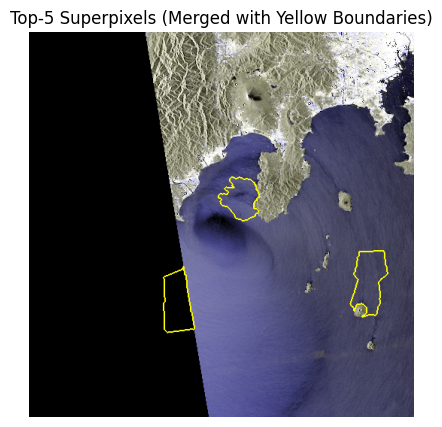

In [43]:
explanation = explain_image(lime_image_np, n_samples=10000)
plot_top_k_segments_with_boundaries(lime_image_np, segments, explanation, k=5, boundary_color=(1, 1, 0))

To-do:
1. complete implementation of LIME with uniform sampling
2. complete bayesian implemtation (reflect on prior choice, starting with simple Gaussian, choice of variance parameter)
3. think about uncertainty for LIME in the case of CNN that are long to train 